<a href="https://colab.research.google.com/github/hardiksiloiya/GANs/blob/main/Music_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.text import Tokenizer
import glob
import numpy as np
import matplotlib.pyplot as plt


In [44]:
from music21 import converter,instrument, note, stream, chord, duration


In [56]:
notes = []
durations = []
for file in glob.glob('temp2/*'):
  print(file)
  mus=converter.parse(file).chordify()
  for element in mus.flat:
    if isinstance(element, chord.Chord):
      notes.append('.'.join(n.nameWithOctave for n in element.pitches))
      durations.append(element.duration.quarterLength)
    if isinstance(element, note.Note):
      if element.isRest:
        notes.append(str(element.name))
        durations.append(element.duration.quarterLength)
      else:
        notes.append(str(element.nameWithOctave))
        durations.append(element.duration.quarterLength)


temp2/beethoven_les_adieux_3.mid
temp2/waldstein_2.mid
temp2/bach_850.mid
temp2/bor_ps2.mid
temp2/chpn_op33_2.mid
temp2/waldstein_3.mid
temp2/beethoven_opus22_3.mid
temp2/mz_333_1.mid
temp2/appass_3.mid
temp2/appass_2.mid
temp2/bor_ps1.mid
temp2/beethoven_hammerklavier_1.mid
temp2/beethoven_opus90_2.mid
temp2/bach_847.mid
temp2/beethoven_opus90_1.mid
temp2/beethoven_opus22_2.mid
temp2/chpn_op27_2.mid
temp2/ty_oktober.mid
temp2/beethoven_opus10_2.mid
temp2/chpn_op27_1.mid
temp2/mz_332_3.mid
temp2/bach_846.mid
temp2/waldstein_1.mid
temp2/beethoven_opus10_3.mid
temp2/ty_september.mid


In [4]:
#for n,d in zip(notes,durations):
#  print(n,"\t",d)
def get_distinct(elem):
  dis=sorted(set(elem))
  num=len(dis)
  return dis,num

In [57]:
note_names,num_notes=get_distinct(notes)
duration_names,num_durations=get_distinct(durations)
note_to_int=dict((elem,num) for num,elem in enumerate(note_names))
dur_to_int=dict((elem,num) for num,elem in enumerate(duration_names))
print(num_notes)
print(num_durations)
dur_to_int

10351
20


{Fraction(1, 12): 0,
 Fraction(1, 6): 1,
 0.25: 2,
 Fraction(1, 3): 3,
 Fraction(5, 12): 4,
 0.5: 5,
 Fraction(2, 3): 6,
 0.75: 7,
 Fraction(11, 12): 8,
 1.0: 9,
 1.25: 10,
 Fraction(4, 3): 11,
 1.5: 12,
 Fraction(5, 3): 13,
 1.75: 14,
 2.0: 15,
 2.5: 16,
 2.75: 17,
 3.0: 18,
 4.0: 19}

In [6]:
xxx=Input(shape=(None,))
yyy=Input(shape=(None,))
x1=Embedding(num_notes,200)(xxx)
y1=Embedding(num_durations,200)(yyy)
z=Concatenate()([x1,y1])
z=LSTM(100,return_sequences=True)(z)
z=LSTM(100,return_sequences=True)(z)
e=Dense(1,activation='tanh')(z)
e=Reshape([-1])(e)
alpha=Activation('softmax')(e)
c=Permute([2,1])(RepeatVector(100)(alpha))
c=Multiply()([z,c])
c=Lambda(lambda temp:K.sum(temp,axis=1))(c)
note=Dense(num_notes,activation='softmax')(c)
duration=Dense(num_durations,activation='softmax')(c)
mod=Model((xxx,yyy),[note,duration])
att=Model([xxx,yyy],alpha)
mod.compile(optimizer=RMSprop(lr=0.005),loss=['categorical_crossentropy','categorical_crossentropy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [7]:
x=[]
y=[]
xnotes=[]
ynotes=[]
xdur=[]
ydur=[]
for i in range(len(notes)-20):
  notesx=notes[i:i+20]
  notesy=notes[i+20]
  durx=durations[i:i+20]
  dury=durations[i+20]
  noteconv=[]
  durconv=[]
  for j in notesx:
    noteconv.append(note_to_int[j])
  for j in durx:
    durconv.append(dur_to_int[j])
  tempx=[noteconv,durconv]
  tempy=[note_to_int[notesy],dur_to_int[dury]]
  x.append(tempx)
  y.append(tempy)
  xnotes.append(noteconv)
  ynotesarr=np.zeros(shape=(num_notes))
  ydurarr=np.zeros(shape=(num_durations))
  ynotesarr[tempy[0]]=1.0
  ydurarr[tempy[1]]=1.0
  ynotes.append(ynotesarr)
  xdur.append(durconv)
  ydur.append(ydurarr)
#xnotes=np.array(xnotes)
xnotes=np.reshape(xnotes,(len(xnotes),20))
#xdur=np.array(xdur)
xdur=np.reshape(xdur,(len(xdur),20))
ynotes=np.reshape(ynotes,(len(ynotes),num_notes))
ydur=np.reshape(ydur,(len(ydur),num_durations))

In [8]:
int_to_note = {v: k for k, v in note_to_int.items()}
int_to_dur = {v: k for k, v in dur_to_int.items()}

In [9]:
print(np.shape(xnotes))
print(np.shape(xdur))
print(np.shape(ydur))
print(np.shape(ynotes))
mod.summary()
net_input=[xnotes,xdur]
net_output=[ynotes,ydur]
xnotes

(47446, 20)
(47446, 20)
(47446, 20)
(47446, 10351)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    2070200     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    4000        input_2[0][0]                    
___________________________________________

array([[1461,  904, 4588, ..., 1312, 5229, 1312],
       [ 904, 4588,  904, ..., 5229, 1312, 5125],
       [4588,  904, 4729, ..., 1312, 5125, 1312],
       ...,
       [1857, 1871,  933, ..., 1940, 1943, 1940],
       [1871,  933,  920, ..., 1943, 1940, 9903],
       [ 933,  920,   90, ..., 1940, 9903, 9899]])

In [52]:
h=mod.fit(x=[xnotes,xdur],y=(ynotes,ydur),epochs=100,batch_size=32)

Epoch 1/100
1483/1483 [==============================] - 29s 20ms/step - loss: 7.4729 - dense_1_loss: 6.9628 - dense_2_loss: 0.5101
Epoch 2/100
1483/1483 [==============================] - 28s 19ms/step - loss: 7.5514 - dense_1_loss: 7.0362 - dense_2_loss: 0.5152
Epoch 3/100
1483/1483 [==============================] - 28s 19ms/step - loss: 7.4335 - dense_1_loss: 6.9250 - dense_2_loss: 0.5085
Epoch 4/100
1483/1483 [==============================] - 28s 19ms/step - loss: 7.4192 - dense_1_loss: 6.9119 - dense_2_loss: 0.5072
Epoch 5/100
1483/1483 [==============================] - 30s 20ms/step - loss: 7.3779 - dense_1_loss: 6.8716 - dense_2_loss: 0.5063
Epoch 6/100
1483/1483 [==============================] - 29s 19ms/step - loss: 7.3578 - dense_1_loss: 6.8524 - dense_2_loss: 0.5053
Epoch 7/100
1483/1483 [==============================] - 29s 20ms/step - loss: 7.3556 - dense_1_loss: 6.8499 - dense_2_loss: 0.5057
Epoch 8/100
1483/1483 [==============================] - 29s 19ms/step - los

KeyboardInterrupt: ignored

In [11]:
mod.save('model')

INFO:tensorflow:Assets written to: model/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: model/assets


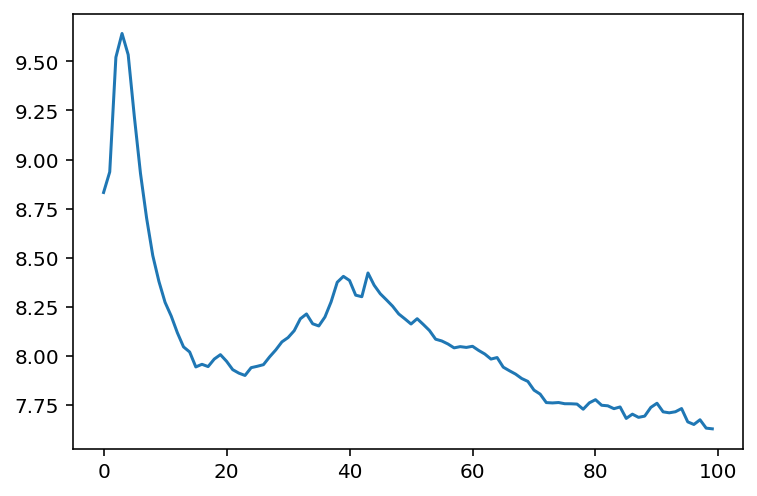

In [53]:
plt.plot(np.arange(100),h.history['loss'])
plt.show()

In [58]:
import random
start=[]
dur=[]
for i in range(20):
  tt=random.choice(note_names)
  ttt=random.choice(duration_names)
  start.append(note_to_int[tt])
  dur.append(dur_to_int[ttt])


for i in range(500):
  testnotes=start[-20:]
  testdur=dur[-20:]
  testnotes=np.reshape(testnotes,(1,20))
  testdur=np.reshape(testdur,(1,20))
  #print(testnotes)
  #print(testdur)
  #print('fff')
  prednote,preddur=mod.predict([testnotes.astype('float32'),testdur.astype('float32')])
  prednote=np.argmax(prednote)
  preddur=np.argmax(preddur)
  #prednote=int_to_note[prednote]
  #preddur=int_to_dur[preddur]
  start.append(prednote)
  dur.append(preddur)

In [59]:
midi_stream = stream.Stream()
for pattern in zip(start,dur):
    note_pattern, duration_pattern = int_to_note[pattern[0]],int_to_dur[pattern[1]]
    # pattern is a chord
    if ('.' in note_pattern):
        notes_in_chord = note_pattern.split('.')
        chord_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(current_note)
            new_note.duration = duration.Duration(duration_pattern)
            new_note.storedInstrument = instrument.Piano()
            chord_notes.append(new_note)
        new_chord = chord.Chord(chord_notes)
        midi_stream.append(new_chord)
    elif note_pattern == 'rest':
    # pattern is a rest
        new_note = note.Rest()
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Piano()
        midi_stream.append(new_note)
    elif note_pattern != 'START':
    # pattern is a note
        new_note = note.Note(note_pattern)
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Piano()
        midi_stream.append(new_note)



midi_stream = midi_stream.chordify()
midi_stream.write('midi','hello.mid')

'hello.mid'